<a href="https://colab.research.google.com/github/ejnunn/GAN_Research/blob/main/notebooks/Image_Editing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prepare Environment

In [1]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip -q install pytorch-fid
!git clone https://github.com/mseitzer/pytorch-fid.git
!rm -r GAN_Research/
!git clone https://github.com/ejnunn/GAN_Research.git

In [6]:
import torch
from torch import nn
from tqdm.auto import tqdm # progress bars
import torchvision
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt # visualizations
import pandas as pd # data processing
import shutil # file management
import torch.nn.functional as F # used in Hyperparameters cell
from skimage import color
import numpy as np
import glob
import os
from skimage import data
from skimage.transform import swirl
from PIL import Image, ImageFilter


torch.manual_seed(0)

# Load Data

In [7]:
warped_dir = '/content/drive/MyDrive/GAN_Research/Datasets/WarpedFace/'

original_img = os.path.join(warped_dir, 'blur', 'blur0.jpg')

# Warp Images

In [28]:
def swirl_image(filepath, rotation=0, strength=4, radius=120):
  '''
  Take an image filepath and swirl the image
  Return the swirled image as a numpy array
  '''
  image = Image.open(filepath)
  image = np.array(image)
  swirled = swirl(image, rotation=rotation, strength=strength, radius=radius)
  swirled = Image.fromarray((swirled * 255).astype(np.uint8)) # convert from 0-1 to 0-255
  return swirled

In [32]:
warped_dir = '/content/drive/MyDrive/GAN_Research/Datasets/WarpedFace/'
forehead_dir = os.path.join(warped_dir, 'forehead_warp')

original_img = os.path.join(warped_dir, 'blur', 'blur0.jpg')

try:
  os.makedirs(forehead_dir)
except:
  pass

rotation = 45
strength = 40
radius = 12
swirled = swirl_image(original_img, rotation=rotation, strength=strength, radius=radius)
swirled.save(os.path.join('.', '{}_{}_{}_test.jpg'.format(rotation, strength, radius)))

In [33]:
!rm *.jpg

# Add noise to Images

In [ ]:
def noisy(noise_typ,image,strength=1):
  if noise_typ == "gauss":
    row,col,ch= image.shape
    mean = 0
    var = 0.1
    sigma = var**0.5
    gauss = np.random.normal(mean,sigma,(row,col,ch))
    gauss = gauss.reshape(row,col,ch)
    noisy = image + (gauss * strength)
    return noisy
  elif noise_typ == "s&p":
    row,col,ch = image.shape
    s_vs_p = 0.5
    amount = 0.004
    out = np.copy(image)
    # Salt mode
    num_salt = np.ceil(amount * image.size * s_vs_p)
    coords = [np.random.randint(0, i - 1, int(num_salt))
            for i in image.shape]
    out[coords] = 1

    # Pepper mode
    num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
    coords = [np.random.randint(0, i - 1, int(num_pepper))
            for i in image.shape]
    out[coords] = 0
    return out
  elif noise_typ == "poisson":
    vals = len(np.unique(image))
    vals = 2 ** np.ceil(np.log2(vals))
    noisy = np.random.poisson(image * vals) / float(vals)
    return noisy
  elif noise_typ =="speckle":
    row,col,ch = image.shape
    gauss = np.random.randn(row,col,ch)
    gauss = gauss.reshape(row,col,ch)        
    noisy = image + (image * gauss * strength)
    return noisy
  else:
    return image

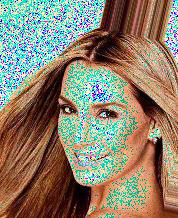

In [ ]:
img_filename = 'img_align_celeba/trainA/000001.jpg'
image = Image.open(img_filename)
img_array = np.array(image)
noisy_array = noisy('speckle', img_array, .075)
noisy_img = Image.fromarray((noisy_array).astype(np.uint8)) # convert from 0-1 to 0-255

In [ ]:
img_dir_to_noise = 'imgs/real_A/'
noisy_dir = 'noisy/'

try:
  os.makedirs(noisy_dir)
except:
  pass

for img in os.listdir(img_dir_to_noise):
  image = Image.open(img_dir_to_noise + img)
  img_array = np.array(image)
  noisy_array = noisy('speckle', img_array, .075)
  noisy_img = Image.fromarray((noisy_array).astype(np.uint8)) # convert from 0-1 to 0-255
  noisy_img.save(noisy_dir + img)

# FID Scoring

In [ ]:
# Calculate FID score for original trainA and trainB datasets
# Only for testing FID functionality
# !python -m pytorch_fid --device cuda imgs/real_B imgs/fake_A
!python -m pytorch_fid --device cuda imgs/real_A swirled/

100% 40/40 [00:05<00:00,  7.10it/s]
Traceback (most recent call last):
  File "/usr/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.7/dist-packages/pytorch_fid/__main__.py", line 3, in <module>
    pytorch_fid.fid_score.main()
  File "/usr/local/lib/python3.7/dist-packages/pytorch_fid/fid_score.py", line 270, in main
    args.dims)
  File "/usr/local/lib/python3.7/dist-packages/pytorch_fid/fid_score.py", line 253, in calculate_fid_given_paths
    dims, device)
  File "/usr/local/lib/python3.7/dist-packages/pytorch_fid/fid_score.py", line 235, in compute_statistics_of_path
    dims, device)
  File "/usr/local/lib/python3.7/dist-packages/pytorch_fid/fid_score.py", line 220, in calculate_activation_statistics
    act = get_activations(files, model, batch_size, dims, device)
  File "/usr/local/lib/python3.7/dist-packages/pytorch_fid/fid_